# History Matching L96
Author: Redouane Lguensat

Date: 26/07/2021

In [1]:
from L96 import * #https://github.com/raspstephan/Lorenz-Online
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
np.random.seed(42)

X_init = 10 * np.ones(36)
X_init[18] = 10 + 0.01

l96_two = L96TwoLevelOriginal(K=36, save_dt=0.001, X_init=X_init, integration_type='coupled') # True params J=10, h=1, F=10, c=10, b=10

In [3]:
l96_two.iterate(10)

#### take the last state as an init for a new simulation
since now we are sure that it starts from the attractor

In [4]:
Newinit = l96_two.history.X[-1,:].values
Newinit

array([ 2.60122824, -0.59213617, -1.17373327,  1.84938332,  8.68045117,
        3.46059218,  0.25781228,  1.2653452 ,  1.08225301,  0.8753893 ,
        8.97733208,  6.18802886,  1.94032476,  1.88401847,  4.37917481,
       -1.81942909, 10.94394167,  3.59440247, -1.43808455, -0.99906739,
       -0.49279472,  2.07853127, -0.63479542, 10.33846187,  5.62458241,
        1.20973551,  1.19944234, -3.27853949, -2.96779466,  4.56265636,
        7.60216092,  2.54621466,  0.40105946, -4.41037045,  1.36549073,
        7.4825951 ])

In [5]:
np.random.seed(42)

l96_two_truth = L96TwoLevelOriginal(K=36, save_dt=0.001, X_init=Newinit, integration_type='coupled') 

In [6]:
l96_two_truth.iterate(100)

This is our ground truth

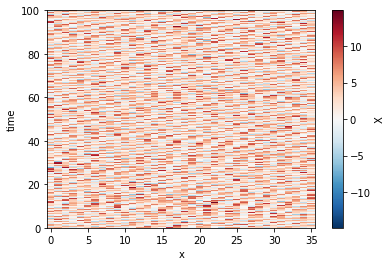

In [7]:
l96_two_truth.history.X.plot()

# Metrics

We will use the 5 terms depicted here as in Schneider et al. 2017. 

$$
\boldsymbol{f}(X, Y)=\left(\begin{array}{c}
\bar{Y} \\
\bar{Y}^{2}
\end{array}\right)
$$

# History Matching

We want to find the parameters (h, c, b)

$\frac{d X_{k}}{d t}=\underbrace{-X_{k-1}\left(X_{k-2}-X_{k+1}\right)}_{\text {Advection}} \underbrace{-X_{k}}_{\text {Diffusion}}+\underbrace{F}_{\text {Forcing}} - \underbrace{\frac{h c}{b} \Sigma_j Y_{j,k}}_{\text {Coupling}}$

$ \frac{d Y_{j, k}}{d t}=\underbrace{-b c Y_{j+1, k}\left(Y_{j+2, k}-Y_{j-1, k}\right)}_{\text {Advection }} \underbrace{- c Y_{j, k}}_{\text {Diffusion }} \underbrace{+\frac{h c}{b} X_{k}}_{\text {Coupling }}$

# Wave1

calculate metrics for the true trajectory

In [8]:
TrueTraj = l96_two_truth.mean_stats(ax=0)[list(range(36,36*2))+list(range(36*4,36*5)),]

Define metric 

In [9]:
def metric(params, Xdata):
    l96param = AMIP(Xdata=Xdata,
                    K=36,
                    save_dt=0.001,
                    X_init=Xdata[0,:],
                    h=params[0],
                    F=10,
                    c=params[1],
                    b=params[2]) 
    l96param.iterate(100)
    return l96param.mean_stats(ax=0)[list(range(36,36*2))+list(range(36*4,36*5)),]

Sanity check with the true params

In [23]:
sancheck = metric(np.array([1,10,10]), l96_two_truth.history.X)

In [24]:
np.mean((TrueTraj - sancheck)**2)

1.7264706673345377e-06

# Running the 30 simulations in parallel

In [10]:
inputs = pd.read_csv("/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/df_inputs_newPCA_PhysPrior_AMIP_wave1.csv").values

In [11]:
inputs

array([[ 1.12691832, 14.62232642,  4.09378654],
       [ 0.49848666, 11.45946401, 11.22699411],
       [ 1.67111857, 10.98365345, 11.96767494],
       [ 1.5146586 ,  3.70297263, 10.93105679],
       [ 0.68479527, 16.00223591, 16.37899668],
       [ 0.42177202, 12.11989284,  4.43567   ],
       [ 0.55900331,  5.70628518,  5.10877828],
       [ 1.28871397,  7.24524619, 17.61956323],
       [ 1.53990535,  8.03739043, 13.26142854],
       [ 1.43874525,  3.10032653, 15.61046465],
       [ 0.18374614, 18.56929322,  8.82844031],
       [ 1.36780028, 13.37952093, 14.28922013],
       [ 0.28496839, 16.94715212,  3.02037319],
       [ 0.62964119,  6.49836454, 12.95219851],
       [ 1.19304042, 15.00003416,  2.33797024],
       [ 0.79475217, 12.58276916, 15.05625627],
       [ 1.23475576,  7.79190094,  2.09576583],
       [ 0.1177242 ,  1.66208107, 10.03782367],
       [ 1.91778143,  9.30225469,  9.36637311],
       [ 0.85588198,  1.26449774,  5.80227169],
       [ 0.06271665, 14.04446628, 14.353

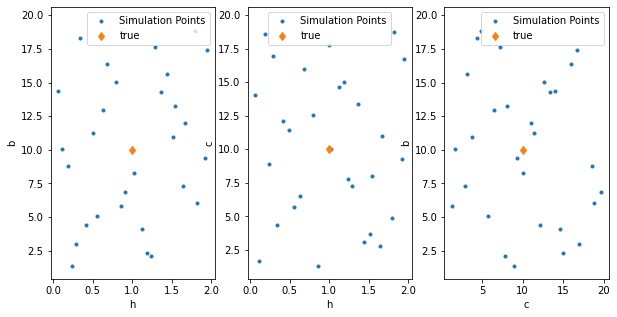

In [12]:
plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
plt.plot(inputs[:,0], inputs[:,2],".", label="Simulation Points")
plt.plot(1, 10,"d", label="true")
plt.xlabel("h")
plt.ylabel("b")
plt.legend()

plt.subplot(1,3,2)
plt.plot(inputs[:,0], inputs[:,1],".", label="Simulation Points")
plt.plot(1, 10,"d", label="true")
plt.xlabel("h")
plt.ylabel("c")
plt.legend()

plt.subplot(1,3,3)
plt.plot(inputs[:,1], inputs[:,2],".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("c")
plt.ylabel("b")
plt.legend()

In [13]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()
num_cores

80

In [14]:
import joblib
joblib.__version__

'1.0.0'

In [15]:
%%time

results = Parallel(n_jobs=30)(delayed(metric)(i, l96_two_truth.history.X) for i in inputs)

targets = np.array(results)

CPU times: user 22.8 s, sys: 4.83 s, total: 27.7 s
Wall time: 2min 53s


In [16]:
inputs = inputs[np.all(np.isfinite(targets), axis=1)]
targets = targets[np.all(np.isfinite(targets), axis=1)]

In [17]:
targets.shape, inputs.shape

((30, 72), (30, 3))

# pca

In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def reduceL96pca(vector):   
    scaler = StandardScaler().fit(vector)
    datascaled = scaler.transform(vector)
    TrueTrajscaled = scaler.transform(TrueTraj[None,:])
    ###########
    pca = PCA(n_components=0.99, svd_solver = 'full')
    pca.fit(datascaled)
    reduceddata = pca.transform(datascaled)
    reducedTrueTraj = pca.transform(TrueTrajscaled)
    return reduceddata, reducedTrueTraj, scaler, pca

In [19]:
targetsreduced, Obsreduced, sc, pc = reduceL96pca(targets)
targetsreduced.shape, Obsreduced.shape

((30, 2), (1, 2))

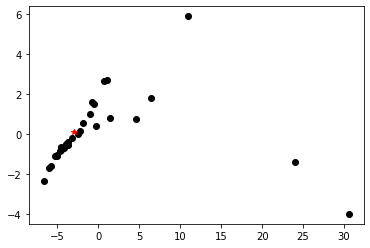

In [26]:
plt.scatter(targetsreduced[:,0],targetsreduced[:,1], color='k')
plt.plot(Obsreduced[:,0],Obsreduced[:,1], 'r*')

### save dataframes

In [21]:
df_metrics = pd.DataFrame()
for i in range(targetsreduced.shape[1]):
    df_metrics['pca_'+str(i)] = targetsreduced[:,i]
df_metrics.to_csv('/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/df_metrics_newPCA_PhysPrior_AMIP_classic_wave1.csv', index=False)

In [22]:
df_metrics

,pca_0,pca_1
0,6.475468,1.820781
1,-4.572506,-0.666303
2,-2.431771,0.007813
3,-2.178001,0.152277
4,-5.077720,-1.067553
5,-0.786884,1.584496
6,-0.590027,1.504720
7,-4.499944,-0.805100
8,-3.180989,-0.229564
9,-3.891521,-0.515363


In [23]:
df_obs_nonoise = pd.DataFrame()
for i in range(targetsreduced.shape[1]):
    df_obs_nonoise['pca_'+str(i)] = Obsreduced[:,i]
df_obs_nonoise.to_csv('/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/df_obs_nonoise_newPCA_PhysPrior_AMIP_classic_wave1.csv', index=False)

## 2) wave 2

In [24]:
inputs2 = pd.read_csv("/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/exp_TuningL94_newPCA_PhysPrior_AMIP_classic_wave2.csv").values

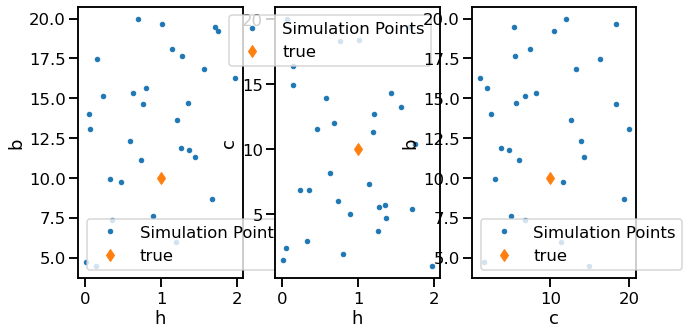

In [25]:
sns.set_context("talk")

plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
plt.plot(inputs2[:,0], inputs2[:,2],".", label="Simulation Points")
plt.plot(1, 10,"d", label="true")
plt.xlabel("h")
plt.ylabel("b")
plt.legend()

plt.subplot(1,3,2)
plt.plot(inputs2[:,0], inputs2[:,1],".", label="Simulation Points")
plt.plot(1, 10,"d", label="true")
plt.xlabel("h")
plt.ylabel("c")
plt.legend()

plt.subplot(1,3,3)
plt.plot(inputs2[:,1], inputs2[:,2],".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("c")
plt.ylabel("b")
plt.legend()

In [26]:
inputs2.shape

(30, 3)

In [27]:
%%time

results2 = Parallel(n_jobs=60)(delayed(metric)(i, l96_two_truth.history.X) for i in inputs2)

targets2 = np.array(results2)

CPU times: user 20.3 s, sys: 4.03 s, total: 24.3 s
Wall time: 2min 52s


In [28]:
inputs2 = inputs2[np.all(np.isfinite(targets2), axis=1)]
targets2 = targets2[np.all(np.isfinite(targets2), axis=1)]

In [20]:
def reduceL96pca_usingwave1(vector, scaler, pca): 
    datascaled = scaler.transform(vector)
    return pca.transform(datascaled)

In [30]:
#targetsreduced2, Obsreduced2, sc2, pc2 = reduceL96pca(targets2)
targetsreduced2 = reduceL96pca_usingwave1(targets2, sc, pc)
targetsreduced2.shape

(30, 2)

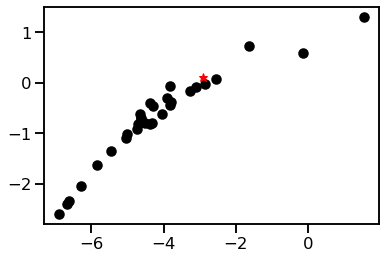

In [31]:
plt.scatter(targetsreduced2[:,0],targetsreduced2[:,1], color='k')
plt.plot(Obsreduced[:,0],Obsreduced[:,1], 'r*')

In [32]:
df_metrics = pd.DataFrame()
for i in range(targetsreduced2.shape[1]):
    df_metrics['pca_'+str(i)] = targetsreduced2[:,i]
df_metrics.to_csv('/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/df_metrics_newPCA_PhysPrior_AMIP_classic_wave2.csv', index=False)

# wave3

In [33]:
inputs3 = pd.read_csv("/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/exp_TuningL94_newPCA_PhysPrior_AMIP_classic_wave3.csv").values

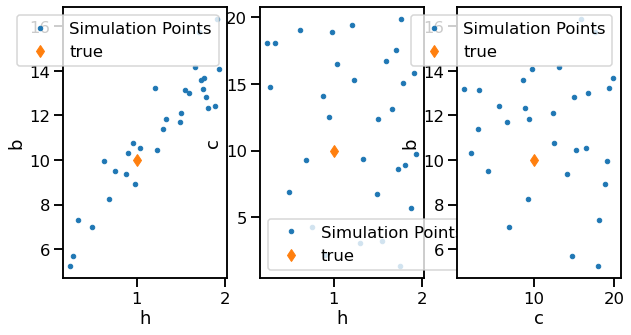

In [34]:
sns.set_context("talk")

plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
plt.plot(inputs3[:,0], inputs3[:,2],".", label="Simulation Points")
plt.plot(1, 10,"d", label="true")
plt.xlabel("h")
plt.ylabel("b")
plt.legend()

plt.subplot(1,3,2)
plt.plot(inputs3[:,0], inputs3[:,1],".", label="Simulation Points")
plt.plot(1, 10,"d", label="true")
plt.xlabel("h")
plt.ylabel("c")
plt.legend()

plt.subplot(1,3,3)
plt.plot(inputs3[:,1], inputs3[:,2],".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("c")
plt.ylabel("b")
plt.legend()

In [35]:
inputs3.shape

(30, 3)

In [36]:
%%time

results3 = Parallel(n_jobs=60)(delayed(metric)(i, l96_two_truth.history.X) for i in inputs3)

targets3 = np.array(results3)

CPU times: user 19.8 s, sys: 4.98 s, total: 24.8 s
Wall time: 2min 52s


In [37]:
inputs3.shape, targets3.shape

((30, 3), (30, 72))

In [38]:
inputs3 = inputs3[np.all(np.isfinite(targets3), axis=1)]
targets3 = targets3[np.all(np.isfinite(targets3), axis=1)]

In [39]:
inputs3.shape, targets3.shape

((30, 3), (30, 72))

In [40]:
targetsreduced3 = reduceL96pca_usingwave1(targets3, sc, pc)
targetsreduced3.shape

(30, 2)

In [41]:
df_metrics = pd.DataFrame()
for i in range(targetsreduced3.shape[1]):
    df_metrics['pca_'+str(i)] = targetsreduced3[:,i]
df_metrics.to_csv('/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/df_metrics_newPCA_PhysPrior_AMIP_classic_wave3.csv', index=False)

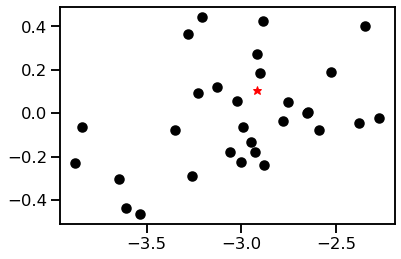

In [42]:
plt.scatter(targetsreduced3[:,0],targetsreduced3[:,1], color='k')
plt.plot(Obsreduced[:,0],Obsreduced[:,1], 'r*')

# wave4

In [43]:
inputs4 = pd.read_csv("/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/exp_TuningL94_newPCA_PhysPrior_AMIP_classic_wave4.csv").values

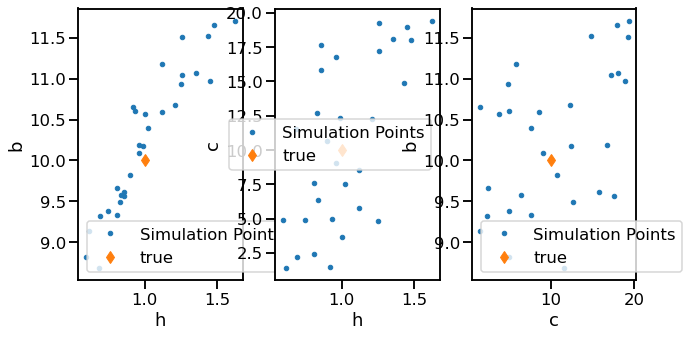

In [44]:
sns.set_context("talk")

plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
plt.plot(inputs4[:,0], inputs4[:,2],".", label="Simulation Points")
plt.plot(1, 10,"d", label="true")
plt.xlabel("h")
plt.ylabel("b")
plt.legend()

plt.subplot(1,3,2)
plt.plot(inputs4[:,0], inputs4[:,1],".", label="Simulation Points")
plt.plot(1, 10,"d", label="true")
plt.xlabel("h")
plt.ylabel("c")
plt.legend()

plt.subplot(1,3,3)
plt.plot(inputs4[:,1], inputs4[:,2],".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("c")
plt.ylabel("b")
plt.legend()

In [45]:
inputs4.shape

(30, 3)

In [46]:
%%time

results4 = Parallel(n_jobs=60)(delayed(metric)(i, l96_two_truth.history.X) for i in inputs4)

targets4 = np.array(results4)

/linkhome/rech/genloc01/udu91zn/.conda/envs/redouaneML/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


CPU times: user 19.5 s, sys: 3.66 s, total: 23.2 s
Wall time: 2min 47s


In [47]:
inputs4.shape, targets4.shape

((30, 3), (30, 72))

In [48]:
inputs4 = inputs4[np.all(np.isfinite(targets4), axis=1)]
targets4 = targets4[np.all(np.isfinite(targets4), axis=1)]

In [49]:
inputs4.shape, targets4.shape

((30, 3), (30, 72))

In [50]:
targetsreduced4 = reduceL96pca_usingwave1(targets4, sc, pc)
targetsreduced4.shape

(30, 2)

In [51]:
df_metrics = pd.DataFrame()
for i in range(targetsreduced4.shape[1]):
    df_metrics['pca_'+str(i)] = targetsreduced4[:,i]
df_metrics.to_csv('/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/df_metrics_newPCA_PhysPrior_AMIP_classic_wave4.csv', index=False)

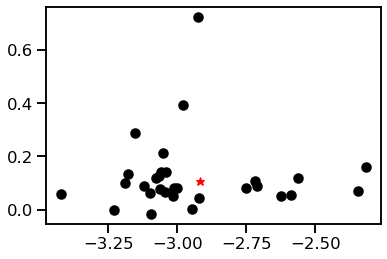

In [52]:
plt.scatter(targetsreduced4[:,0],targetsreduced4[:,1], color='k')
plt.plot(Obsreduced[:,0],Obsreduced[:,1], 'r*')

# wave5

In [53]:
inputs5 = pd.read_csv("/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/exp_TuningL94_newPCA_PhysPrior_AMIP_classic_wave5.csv").values

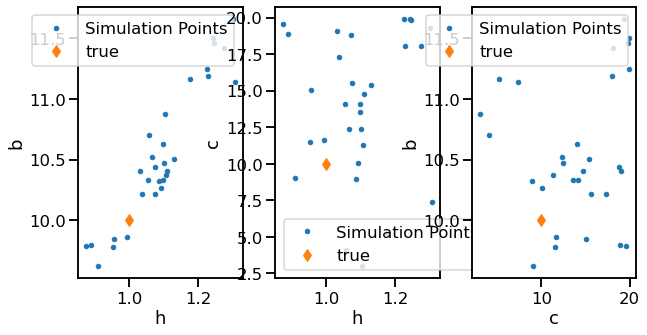

In [54]:
sns.set_context("talk")

plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
plt.plot(inputs5[:,0], inputs5[:,2],".", label="Simulation Points")
plt.plot(1, 10,"d", label="true")
plt.xlabel("h")
plt.ylabel("b")
plt.legend()

plt.subplot(1,3,2)
plt.plot(inputs5[:,0], inputs5[:,1],".", label="Simulation Points")
plt.plot(1, 10,"d", label="true")
plt.xlabel("h")
plt.ylabel("c")
plt.legend()

plt.subplot(1,3,3)
plt.plot(inputs5[:,1], inputs5[:,2],".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("c")
plt.ylabel("b")
plt.legend()

In [55]:
inputs5.shape

(30, 3)

In [56]:
%%time

results5 = Parallel(n_jobs=60)(delayed(metric)(i, l96_two_truth.history.X) for i in inputs5)

targets5 = np.array(results5)

CPU times: user 19.8 s, sys: 5.02 s, total: 24.8 s
Wall time: 3min


In [57]:
inputs5.shape, targets5.shape

((30, 3), (30, 72))

In [58]:
inputs5 = inputs5[np.all(np.isfinite(targets5), axis=1)]
targets5 = targets5[np.all(np.isfinite(targets5), axis=1)]

In [59]:
inputs5.shape, targets5.shape

((30, 3), (30, 72))

In [60]:
targetsreduced5 = reduceL96pca_usingwave1(targets5, sc, pc)
targetsreduced5.shape

(30, 2)

In [61]:
df_metrics = pd.DataFrame()
for i in range(targetsreduced5.shape[1]):
    df_metrics['pca_'+str(i)] = targetsreduced5[:,i]
df_metrics.to_csv('/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/df_metrics_newPCA_PhysPrior_AMIP_classic_wave5.csv', index=False)

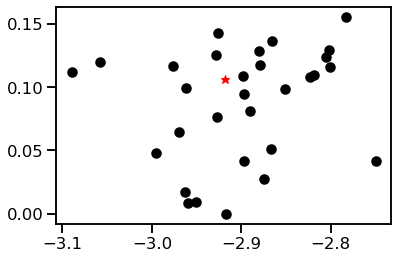

In [62]:
plt.scatter(targetsreduced5[:,0],targetsreduced5[:,1], color='k')
plt.plot(Obsreduced[:,0],Obsreduced[:,1], 'r*')

# Simulate the L96 configurations

In [21]:
def simulate(params, Xdata):
    l96param = AMIP(Xdata=Xdata,
                    K=36,
                    save_dt=0.001,
                    X_init=Xdata[0,:],
                    h=params[0],
                    F=10,
                    c=params[1],
                    b=params[2]) 
    l96param.iterate(100)
    return l96param

In [22]:
configs = pd.read_csv("/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/finaltestpoints_newPCA_PhysPrior_classic_AMIP.csv").values
configs.tolist()

[[1.00078418579932, 10.2619186184871, 10.0328925872761],
 [1.05490159795852, 16.979052995844, 10.4069133946119]]

In [23]:
#pd.read_csv("/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/finaltestpoints_newPCA.csv").to_latex()

In [24]:
simus = [simulate(i, l96_two_truth.history.X) for i in configs.tolist()]

In [25]:
simus_metrics = [ii.mean_stats(ax=0)[list(range(36,36*2))+list(range(36*4,36*5)),] for ii in simus]

In [26]:
simus_metrics = np.array(simus_metrics)
simus_metrics.shape

(2, 72)

In [27]:
simusreduced = reduceL96pca_usingwave1(simus_metrics, sc, pc)
simusreduced.shape

(2, 2)

In [66]:
simus_df = pd.DataFrame()

for i in range(simusreduced.shape[1]):
    simus_df['pc'+str(i)] = simusreduced[:,i]
    
#simus_df.to_csv('/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/configs_metrics_newPCA_PhysPrior_classic_AMIP.csv', index=False)

In [67]:
simus_df

,pc0,pc1
0,-2.920641,0.108397
1,-2.920842,0.102615


### add obs vector

In [68]:
simus_df.loc[len(simus_df)]=list(Obsreduced[0,:])

In [69]:
simus_df

,pc0,pc1
0,-2.920641,0.108397
1,-2.920842,0.102615
2,-2.918674,0.106418


In [70]:
simusdftranspose = simus_df.T
simusdftranspose.columns = ['config1', 'config2','Obs']
simusdftranspose

,config1,config2,Obs
pc0,-2.920641,-2.920842,-2.918674
pc1,0.108397,0.102615,0.106418


ConversionError: Failed to convert value(s) to axis units: Index(['pc0', 'pc1'], dtype='object')

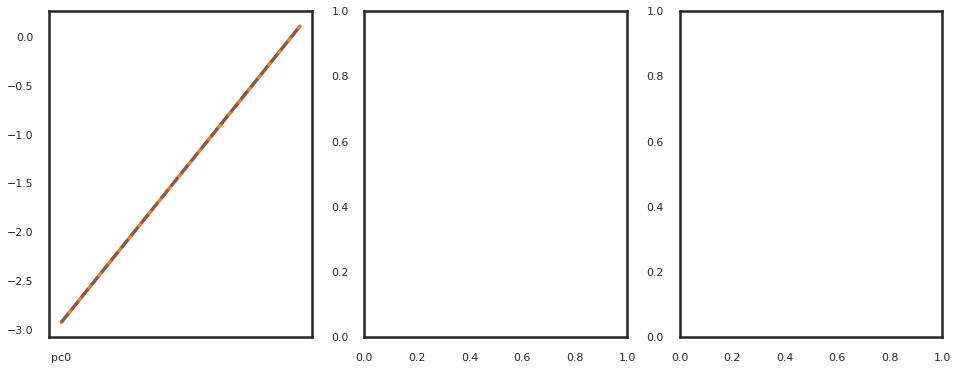

In [94]:
sns.set_style("white")
sns.set_context("poster", font_scale=0.5, rc={"lines.linewidth": 3})

figure, axes = plt.subplots(1, 3, figsize=(16,6))
simusdftranspose['config1'].plot(ax=axes[0])
simusdftranspose['config2'].plot(ax=axes[0])
simusdftranspose['Obs'].plot(linestyle="--", color='tab:brown', ax=axes[0])
axes[0].set_xticks(simusdftranspose.index)
axes[0].legend()

sns.kdeplot(simus[0].history.Y_mean.mean(axis=1), label='config1', ax=axes[1])
sns.kdeplot(simus[1].history.Y_mean.mean(axis=1), label='config2', ax=axes[1])
sns.kdeplot(l96_two_truth.history.Y_mean.mean(axis=1), label='Obs', color='tab:brown', linestyle="--", ax=axes[1])
axes[1].legend()
axes[1].set_xlabel(r'$\bar{Y}$')

sns.kdeplot(simus[0].history.Y2_mean.mean(axis=1), label='config1', ax=axes[2])
sns.kdeplot(simus[1].history.Y2_mean.mean(axis=1), label='config2', ax=axes[2])
sns.kdeplot(l96_two_truth.history.Y2_mean.mean(axis=1), label='Obs', color='tab:brown', linestyle="--", ax=axes[2])
axes[2].legend()
axes[2].set_xlabel(r'$\bar{Y^2}$')

<AxesSubplot:>

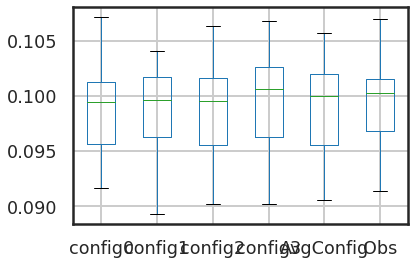

In [105]:
bx_df_Ymean = pd.DataFrame()
bx_df_Ymean['config0'] = simus[0].history.Y_mean.mean(axis=0)
bx_df_Ymean['config1'] = simus[1].history.Y_mean.mean(axis=0)
bx_df_Ymean['config2'] = simus[2].history.Y_mean.mean(axis=0)
bx_df_Ymean['config3'] = simus[3].history.Y_mean.mean(axis=0)

bx_df_Ymean['AvgConfig'] = 0.25*(simus[0].history.Y_mean.mean(axis=0)+
                                 simus[1].history.Y_mean.mean(axis=0)+
                                simus[2].history.Y_mean.mean(axis=0)+
                                simus[3].history.Y_mean.mean(axis=0))
bx_df_Ymean['Obs'] = TrueTraj[0:36*1,]
bx_df_Ymean.boxplot()

In [37]:
from scipy.stats import entropy

def KL_div_obs(sim):
    rangeym=(l96_two_truth.history.Y_mean.mean(axis=1).min().values,
       l96_two_truth.history.Y_mean.mean(axis=1).max().values)
    rangeymsq=(l96_two_truth.history.Y2_mean.mean(axis=1).min().values,
       l96_two_truth.history.Y2_mean.mean(axis=1).max().values)
    return np.median([entropy(np.histogram(sim.history.Y_mean.mean(axis=1), range=rangeym)[0],
                          np.histogram(l96_two_truth.history.Y_mean.mean(axis=1))[0]),
                  entropy(np.histogram(sim.history.Y2_mean.mean(axis=1), range=rangeymsq)[0],
                          np.histogram(l96_two_truth.history.Y2_mean.mean(axis=1))[0])])

[KL_div_obs(sim) for sim in simus]

[0.00189120739841871, 0.002437128213052685]